### Reconstruction errors

This notebook reproduces the experiment quantifying the impact of 
depth and negative slope on the accuracy of both the layer-wise invertible and hybrid architecture.

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from helpers import *
from rec_error_helpers import log_rec, summarize_errors, init_data
from models import IFlatXD, IResXD

/home/tristan/anaconda3/envs/torch4/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [2]:
device = 1
batch_size = 256

dataset = cifar10(root='./data/cifar10')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
train_batches = Batches(Transform(train_set, transforms), batch_size, shuffle=True, 
                        set_random_choices=True, drop_last=True, device=device)
batch  = next(iter(train_batches))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
invert = True
skip_invert = True
invert = True
negative_slope = 0.2
ieps = 0.0001
nlayers=[2, 3, 3]
infeatures = 32
pools = ["channel", "channel"]

# Evolution errors with depth

[3, 3, 3]
[3, 4, 3]
[3, 4, 4]
[4, 4, 4]
[4, 5, 4]
[4, 5, 5]
[5, 5, 5]
[5, 6, 5]
[5, 6, 6]
[6, 6, 6]


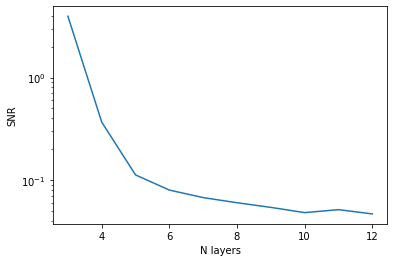

In [4]:
res1 = []
res2 = []

for i in range(10):
    nlayers[i%len(nlayers)]+=1
    print(nlayers)
    
    model = IFlatXD(infeatures=infeatures, invert=invert, layers=nlayers, pools=pools,
                   negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)

    handles, data=log_rec(model)
    inp    = batch["input"].clone()
    target = batch["target"].clone()
    
    output = model(inp)
    output.sum().backward()
    
    df = summarize_errors(data)
    df=df.replace([np.inf, -np.inf], np.nan)
    init_data(data)
    
    res1.append(df["snr"].min())
    res2.append(df["snr"].mean())
    
plt.yscale("log")
plt.ylabel("SNR")
plt.xlabel("N layers")
plt.plot(list(range(3,13)), res1)
plt.savefig("figures/Figure_11")

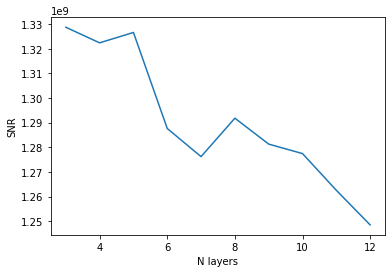

In [5]:
nblock  = 1
nlayers= [0,1,1]

res1 = []
res2 = []

for i in range(10):
    nlayers[i%len(nlayers)]+=1
    
    model   = IResXD(infeatures=infeatures, invert=invert, nlayer=nlayers, nblock=nblock, pools=pools,
                 skip_invert=invert, negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)


    handles, data=log_rec(model)
    inp    = batch["input"].clone()
    target = batch["target"].clone()
    
    output = model(inp)
    output.sum().backward()
    
    df = summarize_errors(data)
    df=df.replace([np.inf, -np.inf], np.nan)
    init_data(data)
    res1.append(df["snr"].min())
    res2.append(df["snr"].mean())
    
plt.ylabel("SNR")
plt.xlabel("N layers")
plt.plot(list(range(3, 13)), res1)
plt.savefig("figures/Figure_14")

# Evolution error with slope

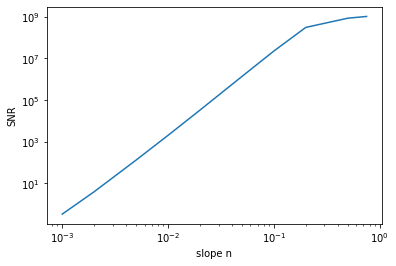

In [6]:
slopes = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75]
nlayers=[1,1,1]
res1 = []
res2 = []

for negative_slope in slopes:
    
    model = IFlatXD(infeatures=infeatures, invert=invert, layers=nlayers, pools=pools,
                   negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
    handles, data=log_rec(model)
    
    inp    = batch["input"].clone()
    target = batch["target"].clone()
    
    output = model(inp)
    output.sum().backward()
    
    df = summarize_errors(data)
    df=df.replace([np.inf, -np.inf], np.nan)
    init_data(data)
    res1.append(df["snr"].min())
    res2.append(df["snr"].mean())
    
plt.ylabel("SNR")
plt.xlabel("slope n")
plt.yscale("log")
plt.xscale("log")
plt.plot(slopes, res1)
plt.savefig("figures/Figure_11_b")

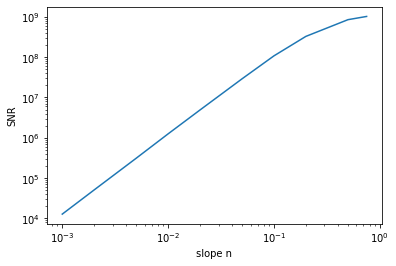

In [7]:
slopes  = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75]
nlayers = [1,1,1]
res1    = []
res2    = []
nblock = 2

for negative_slope in slopes:
    
    model   = IResXD(infeatures=infeatures, invert=invert, nlayer=nlayers, nblock=nblock, pools=pools,
                     skip_invert=invert, negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
    handles, data=log_rec(model)
    
    inp    = batch["input"].clone()
    target = batch["target"].clone()
    
    output = model(inp)
    output.sum().backward()
    
    df = summarize_errors(data)
    df=df.replace([np.inf, -np.inf], np.nan)
    init_data(data)
    res1.append(df["snr"].min())
    res2.append(df["snr"].mean())
    
plt.ylabel("SNR")
plt.xlabel("slope n")
plt.yscale("log")
plt.xscale("log")
plt.plot(slopes, res1)
plt.savefig("figures/Figure_14_b")